# Explanation

Note, this doesn't actually exercise the robust confidence sequence of [Mineiro](2210.11133) because quantile elicitation functions are bounded, but it is here to facilitate understanding of the off-policy techniques.

For a real-valued discrete-time random process $X_t$, the code below constructs a confidence sequence for the CDF of the average historical conditional distribution, $$
\begin{aligned}
\overline{\text{CDF}}_t(v) &\doteq \frac{1}{t} \sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq v}\right],
\end{aligned}
$$
which is simultaneously valid for all times and all values.  It has guaranteed coverage properties, but not guaranteed width.  The inability to guarantee width under dependent data generation without additional assumptions is unavoidable, because threshold functions are [not sequentially uniformly convergent](https://arxiv.org/abs/1006.1138).  This is distinct from the iid setting, where threshold functions are [uniformly convergent with known rates](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality).  For further intuition consult the explicit construction in [Block et. al (2022)](https://arxiv.org/abs/2202.04690) appendix C.5 proposition 4.

[Smoothed distributions](https://arxiv.org/abs/2202.04690) are a tractable class of dependent data scenarios, and the core technique below provides a guaranteed width when the conditional distributions are smooth with respect to the uniform distribution on the unit interval, without requiring knowledge of the smoothness parameter.  This can be extended to a smoothness guarantee against a general reference measure by transformation via the inverse cdf of the reference measure.  For general reference measures with unbounded support but finite mean and variance, a standard [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) provides a smoothness guarantee due to [Chebyshev's inequality](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality); and a [LogLogistic(1/2, 1)](https://en.wikipedia.org/wiki/Log-logistic_distribution) distribution provides a smoothness guarantee for non-negative reference measures with finite mean due to [Markov's inequality](https://en.wikipedia.org/wiki/Markov%27s_inequality).

Computationally the procedure is efficient: the technique requires amortized $O(\log(T))$ compute per data point to ingest $T$ data points, and $O(\log(T))$ compute to calculate the bound for a single value; furthermore the empirical CDF is a sufficient statistic (which is $O(T)$ space).

# Derivation

## Step 1: Test supermartingale for $Y_t \in \{0, 1\}$.

Note this is just the Binomial construction from [Howard et. al.](https://arxiv.org/abs/1810.08240).

$Y_t \in \{ 0, 1 \}$.  Individual means $\theta_t \doteq \mathbb{E}_{t-1}\left[Y_t\right]$, running mean $t \mu_t \doteq \sum_{s \leq t} \theta_s$, and running empirical mean $t \hat{\mu}_t \doteq \sum_{s \leq t} Y_s$.  The following is a martingale by construction $$
\begin{aligned}
E_t(\lambda) &= \exp\left(\lambda t \left(\hat{\mu}_t -\mu_t\right) - \sum_{s \leq t} \log\left(h(\lambda, \theta_s)\right) \right)  & \left( h(\lambda, z) \doteq (1 - z) e^{-\lambda z} + z e^{\lambda (1 - z)} \right) \\
\mathbb{E}_{t-1}\left[E_t(\lambda)\right] &= E_{t-1}(\lambda)  \mathbb{E}_{t-1}\left[\exp\left(\lambda \left(-\theta_t + Y_t\right) - \log\left(h(\lambda, \theta_t)\right)\right)\right] = E_{t-1}(\lambda),
\end{aligned}
$$ and is bounded below by $$
\begin{aligned}
E_t(\lambda) &\geq \exp\left(\lambda t \left(\hat{\mu}_t -\mu_t\right) - t \log\left(h(\lambda, \mu_t)\right) \right) & \left(\dagger\right) \\
&\doteq \left(\frac{p}{\mu_t}\right)^{t \hat{\mu}_t} \left(\frac{1 - p}{1 - \mu_t}\right)^{t (1 - \hat{\mu}_t)}, & \left(p \doteq \frac{\mu_t e^\lambda}{1 + (e^\lambda - 1) \mu_t}\right)
\end{aligned}
$$ 
where $(\dagger)$ follows from $\left( t f(q) = \max_{\theta \bigl| 1^\top \theta=t q} \sum_{s \leq t} f(\theta_s) \right)$ for any concave $f$.  


**Analytical Mixture**: Let $$
\begin{aligned}
W_t(b; \hat{\mu}_t, \mu_t) &= \frac{\int_{\mu_t}^1 d\text{Beta}\left(p; b \mu_t, b (1 - \mu_t)\right)\ \left(\frac{p}{\mu_t}\right)^{t \hat{\mu}_t} \left(\frac{1 - p}{1 - \mu_t}\right)^{t (1 - \hat{\mu}_t)}}{\int_{\mu_t}^1 d\text{Beta}\left(p; b \mu_t, b (1 - \mu_t)\right)} \\
&= \frac{1}{(1 - \mu_t)^{t (1 - \hat{\mu}_t)} \mu_t^{t \hat{\mu}_t}} \left(\frac{\text{Beta}(\mu_t, 1, b \mu_t + t \hat{\mu}_t, b (1 - \mu_t) + t (1 - \hat{\mu}_t))}{\text{Beta}(\mu_t, 1, b \mu_t, b (1 - \mu_t))}\right) \\
\end{aligned}
$$
where $\text{Beta}(a,1,c,d)$ is the [Mathematica version](https://reference.wolfram.com/language/ref/Beta.html).  Scipy provides [betainc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.betainc.html) and [betaln](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.betaln.html).  In case of numerical difficulties, we fall back to a Gaussian approximation.

## Step 2: Use a countably infinite collection of intervals

The $n$-th intervals models $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq u(n)}\right]$ via the test supermartingale.  Let $\alpha(n) \geq 0$ define a (decreasing) assignment of probability with $1 \geq \sum_{n=1}^\infty \alpha(n)$ for a union bound, e.g., $\alpha(n) = 6 / (\pi^2 n^2)$.

Although we have a countable infinite number of intervals covered with a union bound, there is no point in evaluating past the point where the bounds can improve.  Specifically, if all counts are to the left of the probe, there is no point in further refining the upper boundary.

## Step 3: Arbitrary Support

Suppose we know $\mathbb{P}_t$ is smooth wrt a distribution $M$ dominated by Lebesque (i.e., which does not charge points), $$
\begin{aligned}
\frac{d\mathbb{P}_t}{dM} &\leq \xi^{-1}.
\end{aligned}
$$ Let $\phi(v) \doteq M(X \leq v)$ be the CDF of $M$ and let $Y_t \doteq \phi(X_t)$.  Then the CDF of $Y_t$ at $\phi(v)$ is the CDF of $X_t$ at $v$.  $$
\begin{aligned}
\frac{d\mathbb{P'}_t/d\lambda}{dM/d\lambda} &= \frac{d\mathbb{P'}_t/d\lambda}{dU} \\
\frac{d\mathbb{P'}_t}{d\lambda}(Y_t) &= \frac{d\mathbb{P}_t}{d\lambda}(\phi^{-1}(Y_t)) \left( \left. \frac{d}{dz} \phi^{-1}(z) \right|_{z=y} \right) 
\end{aligned}
$$

$$
\begin{aligned}
\mathbb{P}_t\left(Y \in B\right) &= \mathbb{P}_t\left(X_t \in \phi^{-1}(B)\right) \\
&= \int_{\phi^{-1}(B)} \frac{d\mathbb{P}_t}{dM} dM \\
&= \int_{B} \frac{d\mathbb{P}_t}{dM}\left(\phi^{-1}\right) \left(\phi^{-1}\right)' dM
\end{aligned}
$$

# Code

In [1]:
class StreamingECDF(object):
    class FrozenECDF(object):
        def __init__(self, rawsd):
            from sortedcontainers import SortedDict
            super().__init__()
        
            self.sd = SortedDict()
            
            cumsum = 0
            for k, v in rawsd.items():
                cumsum += v
                self.sd[k] = cumsum
            
            self.tot = cumsum

        def __call__(self, H):
            if H is None:
                return self.tot
            
            hgeindex = self.sd.bisect_right(H)
            if hgeindex != len(self.sd):
                _, Hcnt = self.sd.peekitem(hgeindex)
            else:
                Hcnt = self.tot
                
            assert Hcnt <= self.tot, (Hcnt, H, self.tot)
            return Hcnt

    def __init__(self):
        from sortedcontainers import SortedDict
        super().__init__()
        
        self.sd = SortedDict()
        self.tot = 0
        
    def addobs(self, x):
        from numbers import Number
        assert isinstance(x, Number), x
        
        self.sd.setdefault(x, 0)
        self.sd[x] += 1
        self.tot += 1
        
    def freeze(self):
        return StreamingECDF.FrozenECDF(self.sd)

def getCSUpperBound(c, t, logp, b=1):
    from math import log
    from scipy.optimize import root_scalar
    
    assert t >= 1
    assert 0 <= c <= t
    muhat = c / t    
    thres = -logp

    def logwealth(mu):
        def logbetacdf(p, betaa, betab):
            from math import isfinite, log, log1p, sqrt
            from scipy.special import betainc, erf
            
            try:
                rv = log(betainc(betaa, betab, p))
                assert isfinite(rv)
            except:
                from scipy.stats import norm
                
                mean = betaa / (betaa + betab)
                var = betaa * betab / ((betaa + betab)**2 * (1 + betaa + betab))
                
                # The cumulative of the unit normal distribution is given by Phi(z) = 1/2[1 + erf(z/sqrt(2))].
                z = (p - mean) / sqrt(var)
                
                if z < -5 * sqrt(2):
                    from math import pi
                    rv = -z**2/2 - (1/2)*log(2*pi) - 5 * log(abs(z)) + log(3 - z**2 + z**4) # + O(log(1/z^7))
                else:
                    from math import erf
                    rv = -log(2) + log1p(erf(z/sqrt(2)))
                                
            assert isfinite(rv), (p, betaa, betab, rv)
            
            return rv
                
        from math import log1p, isfinite
        from scipy.special import betaln
        
        assert 0 < mu < 1
        
        numa, numb = b * mu + t * muhat, b * (1 - mu) + t * (1 - muhat)
        dena, denb = b * mu, b * (1 - mu)
        
        logsfnumerator = logbetacdf(p=mu, betaa=numa, betab=numb)
        logsfdenominator = logbetacdf(p=mu, betaa=dena, betab=denb)
        logbetanum = betaln(numa, numb)
        logbetaden = betaln(dena, denb)
        
        return -t * (1 - muhat) * log1p(-mu) - t * muhat * log(mu) + logbetanum + logsfnumerator - logbetaden - logsfdenominator
    
    mumin = max(muhat, 1/t)
    mumax = 1 - 1/t
    if mumin >= mumax or logwealth(mumax) <= thres:
        return 1
    
    if logwealth(mumin) >= thres:
        return mumin
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax])
    assert res.converged
    return res.root

def getUnifUpperBound(probe, counts, conf):
    from math import log, ceil, pi
    
    ub0H = 1
    
    log6opsq = log(6/pi**2)
    logconf = log(conf)
    
    t = counts(None)
    cprobe = counts(probe)
    
    # technically depth range(1, infinity)
    # in practice we have finite numerical precision
    for depth in range(1, 200):
        # grid is (k / 2**depth) for k in [1, \ldots, 2**depth]
        # even values of k are duplicates from prior grids
        # hence size of grid not already covered is 2**(depth-1)
        
        logp = log6opsq - 2 * log(depth) - (depth - 1) * log(2)
        #                 ^--- union bound over depth
        #                                   ^--- shared by 2^(depth-1) 
        
        kupper = max(1, ceil(2**depth * probe))
        if kupper % 2 == 1:
            vupper = kupper / 2**depth
            cupper = counts(vupper) 
            ub0H = min(ub0H, getCSUpperBound(cupper, t, logp + logconf))
            if cupper <= cprobe:
                break
            
    return ub0H

def getGenericUpperBound(probe, counts, conf, *, refcdf, refppf):
    return getUnifUpperBound(refcdf(probe), lambda h: counts(None) if h is None else counts(refppf(h)), conf)

def getGenericLowerBound(probe, counts, conf, *, refsf, refisf):
    from math import inf
    return 1 - getUnifUpperBound(refsf(probe), lambda h: counts(None) if h is None else counts(None) - counts(refisf(h)), conf)

# IID Examples
In the examples below, a time-uniform version of [DKW](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) is shown as a baseline just to get an idea of the empirical performance of the technique.  Note DKW does not hold for general data dependent generation.

In [2]:
def plotit(data, true, ref, extra=[], titles=[None]*3, files=[None]*3, compare=[], hacks=[None]*3):
    from math import sqrt, log, pi
    from scipy.interpolate import interp1d
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    T = len(data)    
    nxvals = 1000

    ecdfx = np.sort(data)
    ecdfy = np.arange(1, len(data)+1)/float(len(data))
    probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
    ecdff = interp1d(x=ecdfx, y=ecdfy, fill_value=(0, 1), kind='previous', bounds_error=False)
    ecdffunc = np.array([ ecdff(v) for v in probevals ])

    exactcdfy = np.array([ true.cdf(x) for x in probevals ])
    
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ecdffunc - exactcdfy, label='empirical minus exact cdf')
    
    counts = StreamingECDF()
    for x in data:
        counts.addobs(x)        
    icey = counts.freeze()
    lbcdfy = np.array([ getGenericLowerBound(x, icey, conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
    start = time.time()
    ubcdfy = np.array([ getGenericUpperBound(x, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
    end = time.time()

    plt.plot(probevals, ubcdfy - exactcdfy, label='cdf ub minus exact')
    plt.plot(probevals, exactcdfy - lbcdfy, label='cdf exact minus lb')
    plt.title(titles[0] or 'difference between bounds and exact CDF')
    plt.legend()
    if files[0]:
        plt.savefig(files[0], bbox_inches='tight')
    
    # DKW
    logtuconf = log(conf) + log(6/pi**2) - 2*log(T)
    dkwtueps = sqrt((log(2) - logtuconf) / (2 * T))
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-v0_8-deep')
    plt.plot(probevals, ubcdfy - lbcdfy, color=f'C1', label=f'{true.desc}')
    minprobevals, maxprobevals = min(probevals), max(probevals)
    for n, t in enumerate(compare):
        counts = StreamingECDF()
        for x in t.data:
            counts.addobs(x)        
        icey = counts.freeze()
        compecdfx = np.sort(t.data)
        compecdfy = np.arange(1, len(t.data)+1)/float(len(t.data))
        compprobevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=compecdfy, fp=compecdfx, left=0, right=1)
        complbcdfy = np.array([ getGenericLowerBound(x, icey, conf / 2, refsf = ref.sf, refisf = ref.isf) for x in compprobevals ])
        compubcdfy = np.array([ getGenericUpperBound(x, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in compprobevals ])
        plt.plot(compprobevals, compubcdfy - complbcdfy, color=f'C{n+2}', label=f'{t.desc}')
        minprobevals, maxprobevals = min(minprobevals, min(compprobevals)), max(maxprobevals, max(compprobevals))
    plt.plot([minprobevals, maxprobevals], [2*dkwtueps]*2, color=f'C0', linestyle='dashed', label=f'Time uniform DKW')
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$U_t(v) - L_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[1] or f'bound widths for T={T} draws from {true.desc}', fontsize=megafs+6)
    if hacks[1]:
        hacks[1](fig, ax)
    if files[1]:
        plt.savefig(files[1], bbox_inches='tight')
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-v0_8-deep')
    plt.plot(probevals, exactcdfy, label='true cdf', color=f'C0', linestyle=linestyle_tuple[0][1], linewidth=megalw)
    for n, t in enumerate(extra):
        counts = StreamingECDF()
        for x in data[:t]:
            counts.addobs(x)        
        icey = counts.freeze()
        extralbcdfy = np.array([ getGenericLowerBound(x, icey, conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
        extraubcdfy = np.array([ getGenericUpperBound(x, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
        plt.plot(probevals, extralbcdfy, label=f'$t={t}$', color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
        plt.plot(probevals, extraubcdfy, label=None, color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
    plt.plot(probevals, lbcdfy, label=f'$t={T}$', color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    plt.plot(probevals, ubcdfy, label=None, color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$\\overline{CDF}_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[2] or f'ubcdf calc time for T={T} at {nxvals} evenly spaced x-values: {end-start:.3f} s', fontsize=megafs+6)
    if hacks[2]:
        hacks[2](fig, ax)
    if files[2]:
        plt.savefig(files[2], bbox_inches='tight')

## Increasingly narrow uniform distribution near 0

extra = [ 10000  12742  16237  20691  26366  33598  42813  54555  69519  88586
 112883 143844 183298 233572 297635 379269 483293 615848 784759]


epsilon:   0%|          | 0/25 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

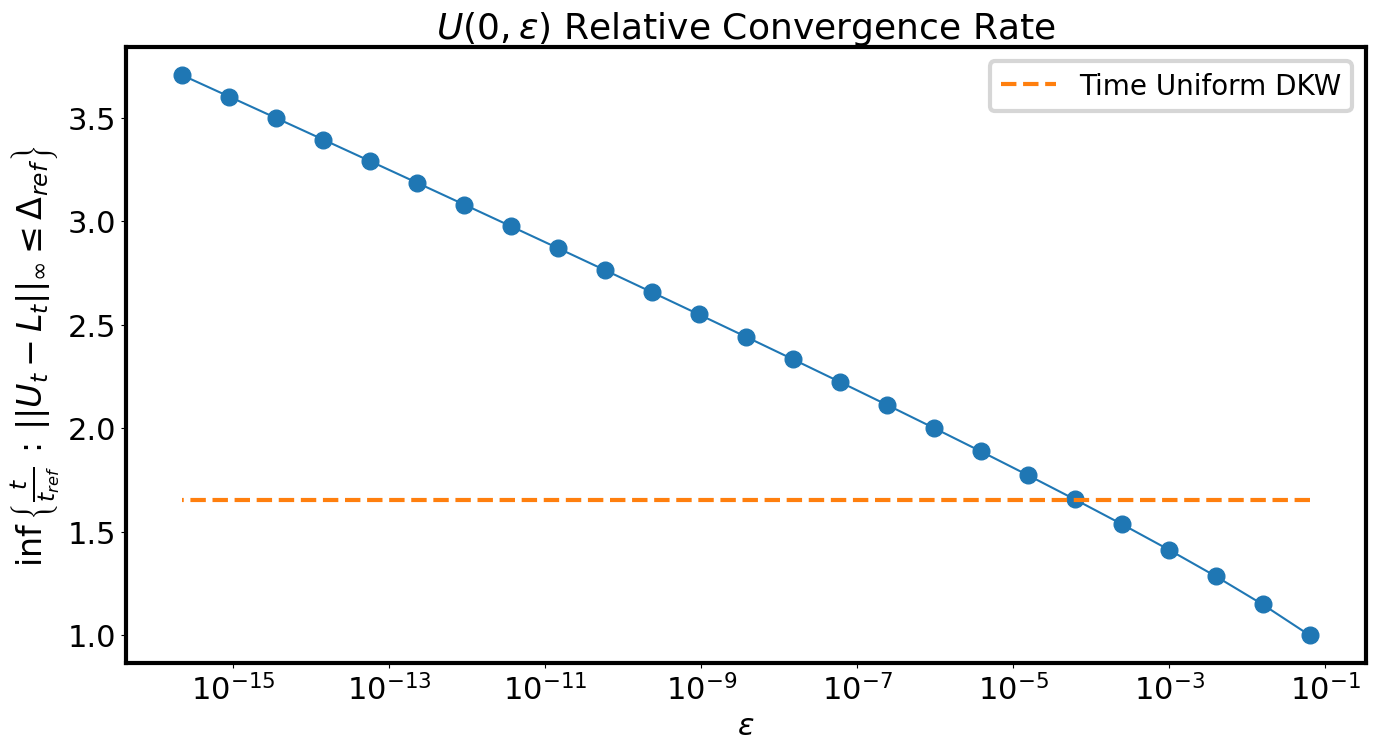

In [3]:
def ultraplotsupnorm(datasets, trues, ref, extra=[], title=None, hack=None, file=None):
    from tqdm.notebook import tqdm
    from math import sqrt, log, pi, exp
    from scipy.interpolate import interp1d
    from scipy.optimize import root_scalar
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    from fractions import Fraction
    
    print(f'extra = {extra}')
        
    markers = "ov>^<8pP"
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-v0_8-deep')
    
    params = []
    relativeconvergence = []
    for n, (data, true) in tqdm(list(enumerate(zip(datasets, trues))), desc='epsilon', position=0, leave=False):
        times = []
        supnorms = []
        for t in itertools.chain(extra, [len(data)]):
            counts = StreamingECDF()
            for x in data[:t]:
                counts.addobs(x)        
            icey = counts.freeze()
            lbmode = getGenericLowerBound(true.mode, icey, conf / 2, refsf = ref.sf, refisf = ref.isf)
            ubmode = getGenericUpperBound(true.mode, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf)
            times.append(t)
            supnorms.append(ubmode-lbmode)
            if n == 0:
                break
            elif log(supnorms[-1]) < baseline:
                break
                        
        params.append(true.param)
        
        if n == 0:
            baseline = log(supnorms[0])
            basedesc = true.desc
            relativeconvergence.append(1)
            # DKW
            def dkwtuwidth(tau):
                logtuconf = log(conf) + log(6/pi**2) - 2*log(tau)
                return 2*sqrt((log(2) - logtuconf) / (2 * tau))
            res = root_scalar(lambda tau: log(dkwtuwidth(tau)) - baseline, bracket=[ 1, 10*len(data) ])
            assert res.converged, res
            dkwmatch = res.root / times[0]
        else:
            empwidth = interp1d(x=np.log(times), y=np.log(supnorms))
            try:
                res = root_scalar(f=lambda logt: empwidth(logt) - baseline, bracket=[log(times[0]), log(times[-1])])
                assert res.converged, res
            except:
                print(true.param)
                print(true.mode)
                print(times)
                print(supnorms)
                print(exp(baseline))
                plt.plot(np.log(times), [baseline]*len(times), linestyle='dashed')
                plt.plot(np.log(times), [empwidth(logt) for logt in np.log(times)])
                plt.figure()
                raise
            relativeconvergence.append(exp(res.root - log(times[0])))

    plt.plot(params, relativeconvergence, marker=markers[0], markersize=megafs-8)
    plt.plot([ params[0], params[-1] ], [dkwmatch]*2, label='Time Uniform DKW', linestyle='dashed', linewidth=megalw)

        
    ax.set_xlabel(f'$\\epsilon$', fontsize=megafs+2)
    ax.set_ylabel(f'$\inf \\left\\{{ \\frac{{t}}{{t_{{ref}}}} \\,:\\, || U_t - L_t ||_{{\\infty}} \leq \\Delta_{{ref}} \\right\\}}$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(title or f'wazzup', fontsize=megafs+6)
    if hack:
        hack(fig, ax)
    if file:
        plt.savefig(file, bbox_inches='tight')

def flass():
    from math import ceil
    import numpy as np
    from numpy.random import default_rng
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    logbase10T = 6
    T = ceil(10**logbase10T)
    
    datasets = []
    trues = []
    seed = 4548
    for poweps in range(-4, -54, -2):
        epsilon = 2**poweps
        rng = default_rng(seed)
        data = rng.uniform(low=0, high=epsilon, size=T)
        true = Anon(desc = f'$\\epsilon = 2^{{{poweps}}}$', param = epsilon, mode = 1/2 * epsilon)
        datasets.append(data)
        trues.append(true)
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    ultraplotsupnorm(datasets, trues, ref,
                     extra=np.logspace(start=4, stop=logbase10T, num=20)[:-1].astype(int),
                     title='$U(0, \\epsilon)$ Relative Convergence Rate',
                     hack=lambda fig, ax: (ax.set_xscale('log'), ),
                     file='uniformsweep.pdf')

flass()

## Beta(5,3) distribution
Using the uniform$([0,1])$ distribution as reference measure.

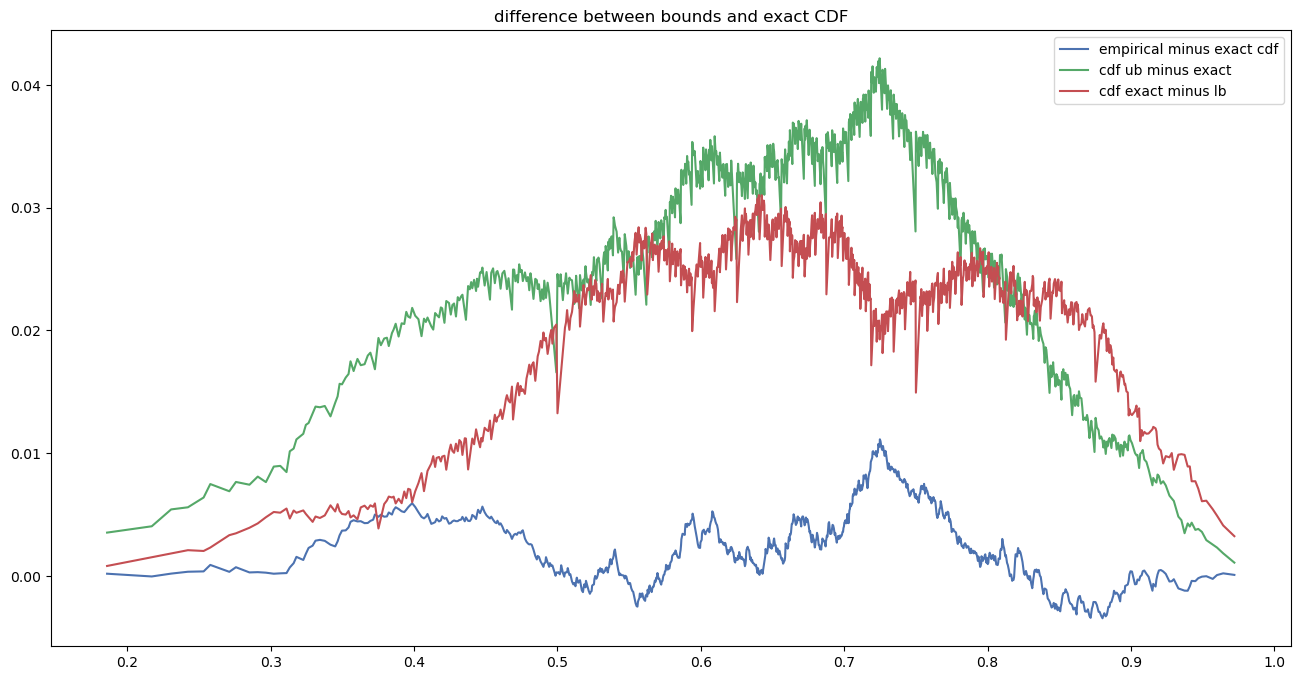

<Figure size 640x480 with 0 Axes>

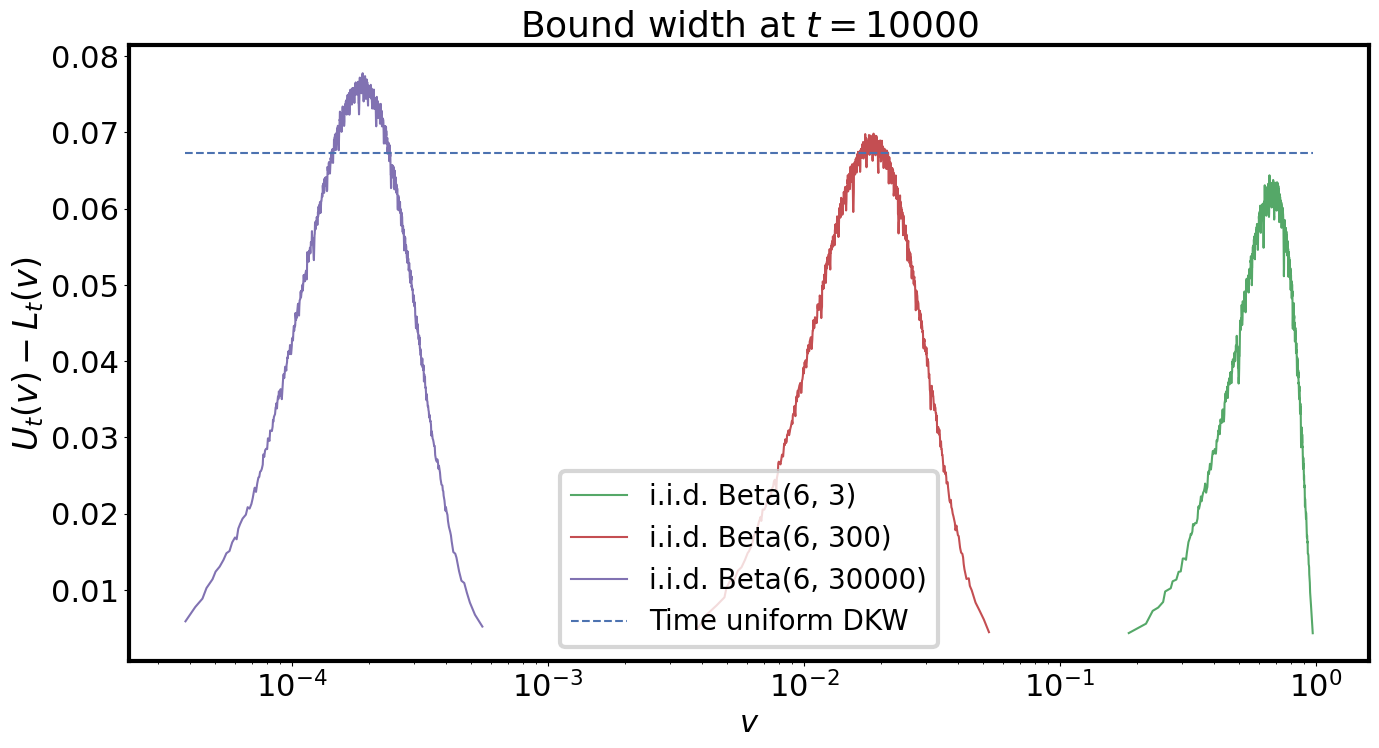

<Figure size 640x480 with 0 Axes>

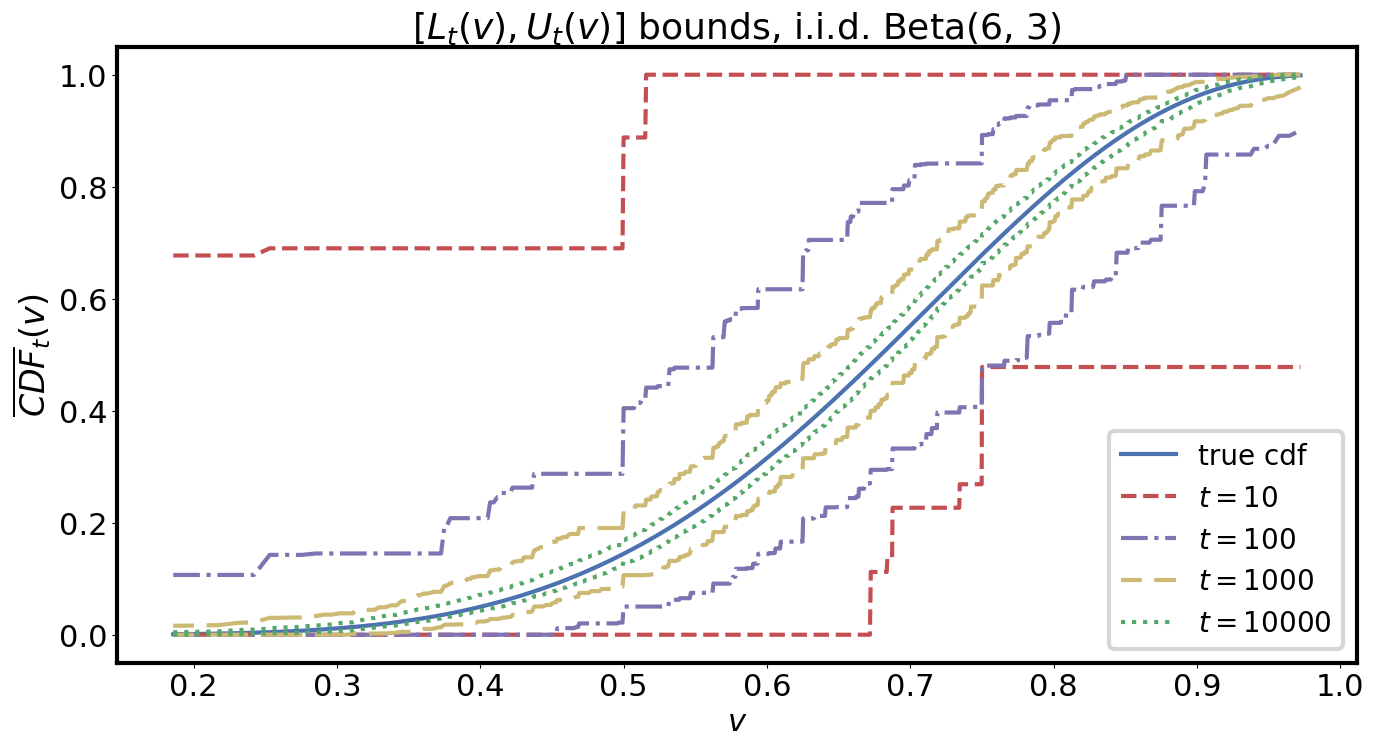

In [4]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 6, 3
    T = 10000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'i.i.d. Beta({betaa}, {betab})',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
        
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
        
    plotit(data, true, ref, 
           extra=[10, 100, 1000], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, {true.desc}'],
           files=[None, 'betaboundwidth.pdf', 'betacurves.pdf'],
           compare=[
                    Anon(desc = f'i.i.d. Beta({betaa}, {betab*mult})',
                         data = rng.beta(betaa, betab*mult, size=T)
                        )
                    for mult in (100, 10000,)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()

## Lognormal Distribution (supported on $[0, \infty)$)
Using a LogLogistic(1/2, 1) as the reference measure.

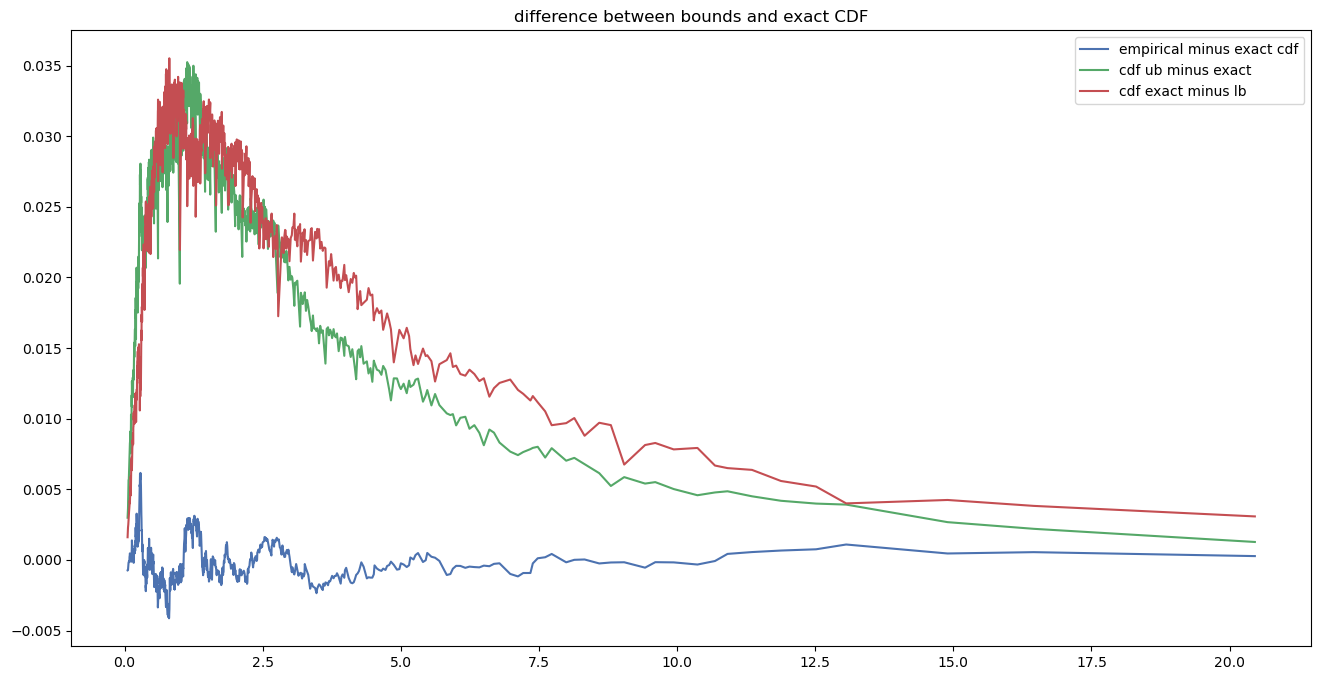

<Figure size 640x480 with 0 Axes>

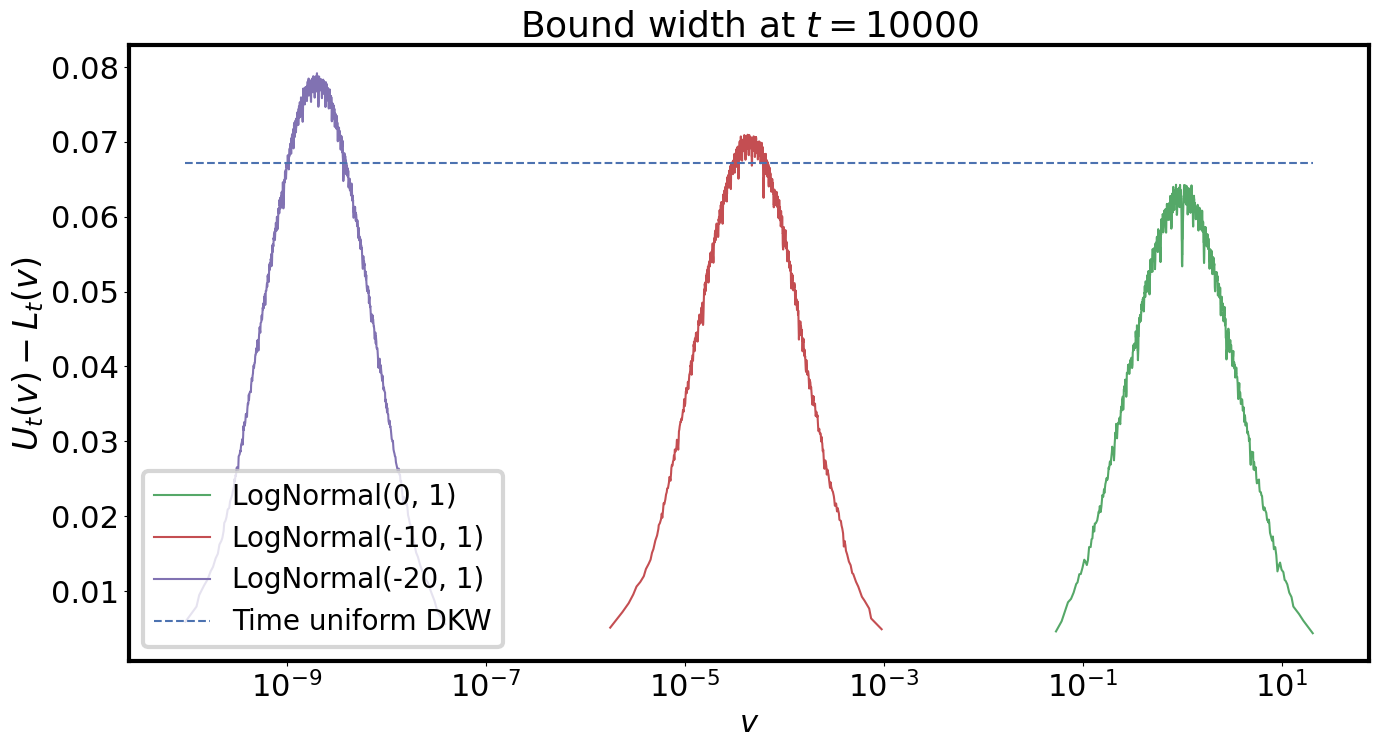

<Figure size 640x480 with 0 Axes>

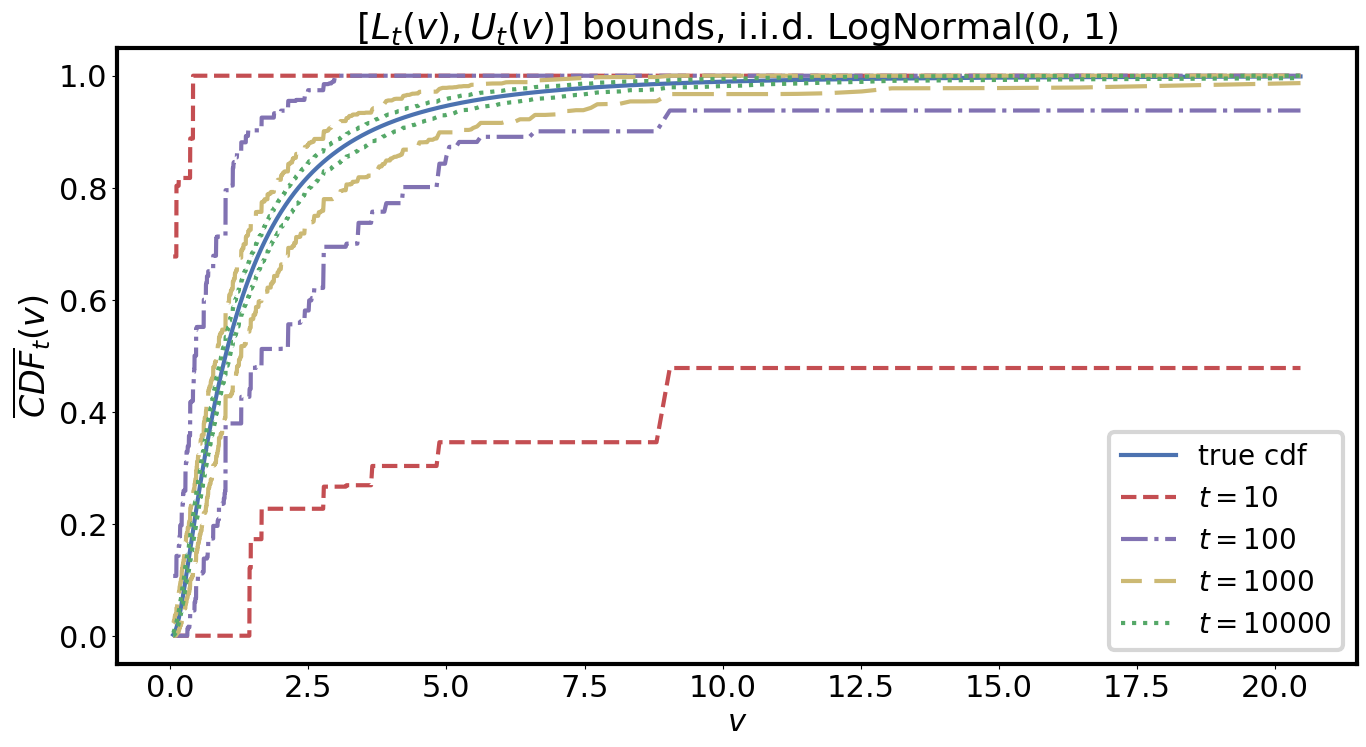

In [5]:
def flass(seed=4546):
    from math import exp, erfc, log, sqrt, atan, pi, tan
    from numpy.random import default_rng

    mu, sigma = 0, 1
    T = 10000
    
    rng = default_rng(seed)
    data = rng.lognormal(mu, sigma, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'LogNormal({mu}, {sigma})',
                cdf = lambda slf, x: 0 if x <= 0 else 1/2 * erfc((mu - log(x))/(sqrt(2)*sigma)),
               )
    
    ref = Anon(cdf = lambda slf, x: 1/(1 + 1/sqrt(x)),
               ppf = lambda slf, x: x**2 / (1 - x)**2,
               sf = lambda slf, x: 1 / (1 + sqrt(x)),
               isf = lambda slf, x: (1 - x)**2 / x**2,
              )
    
    plotit(data, true, ref, extra=[10, 100, 1000], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, i.i.d. LogNormal({mu}, {sigma})'],
           files=[None, 'lognormalboundwidth.pdf', 'lognormalcurves.pdf'],
           compare=[Anon(desc = f'LogNormal({mu - shift}, {sigma})',
                         data = rng.lognormal(mu - shift, sigma, size=T)
                        )
                    for shift in (10, 20)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()

## Gaussian Distribution (supported on $(-\infty, \infty)$)
Using a standard Cauchy as the reference measure.

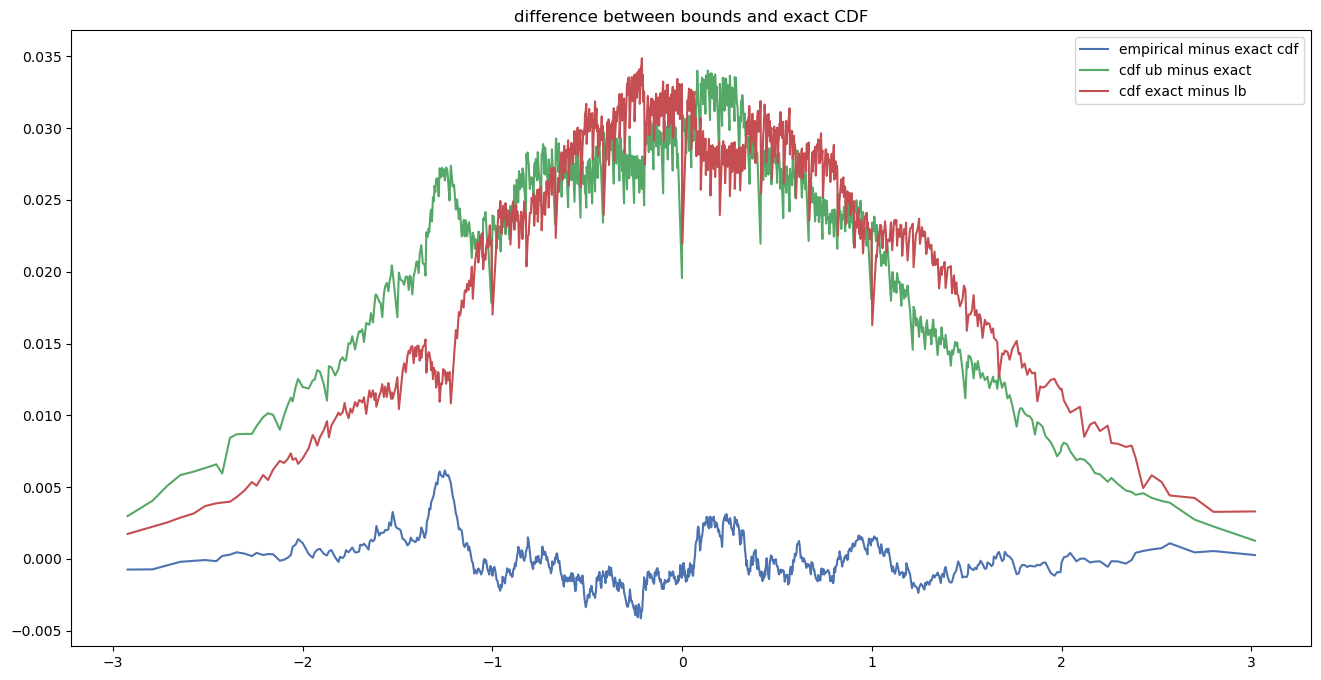

<Figure size 640x480 with 0 Axes>

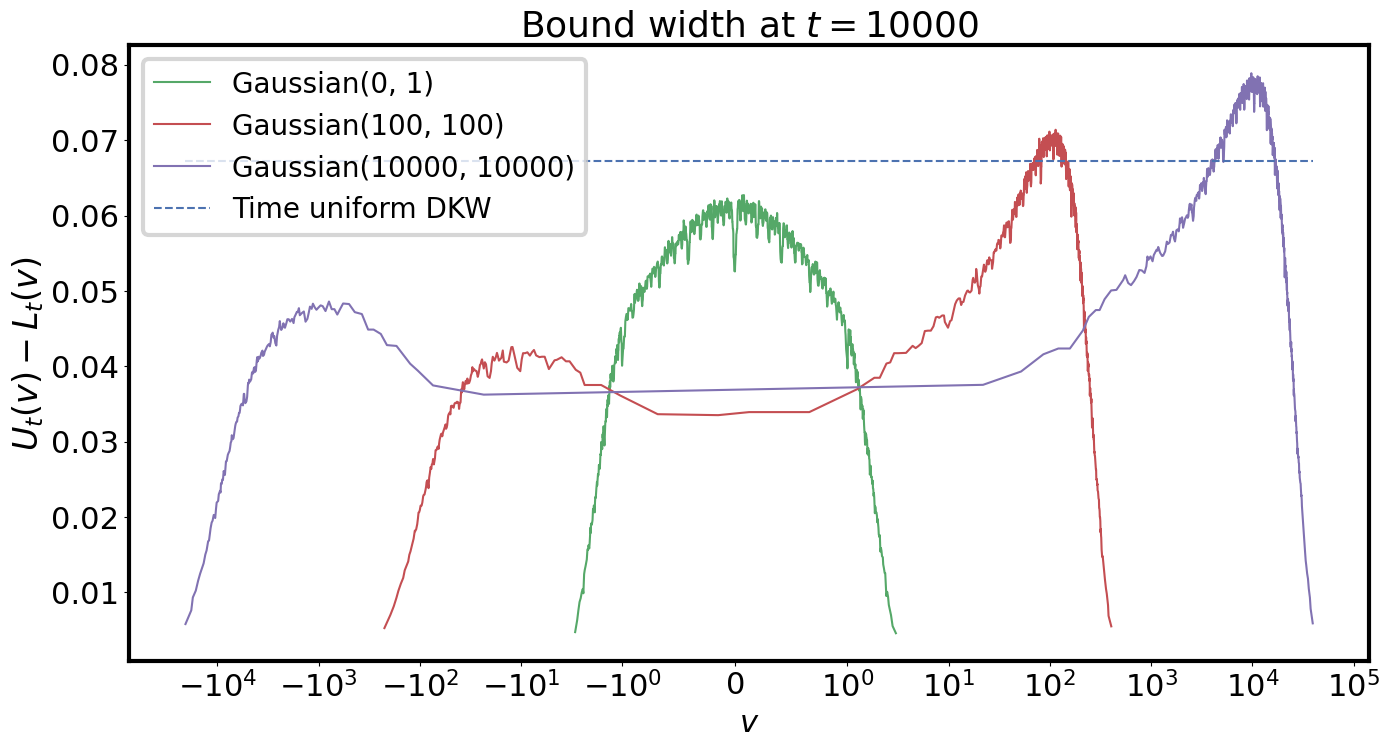

<Figure size 640x480 with 0 Axes>

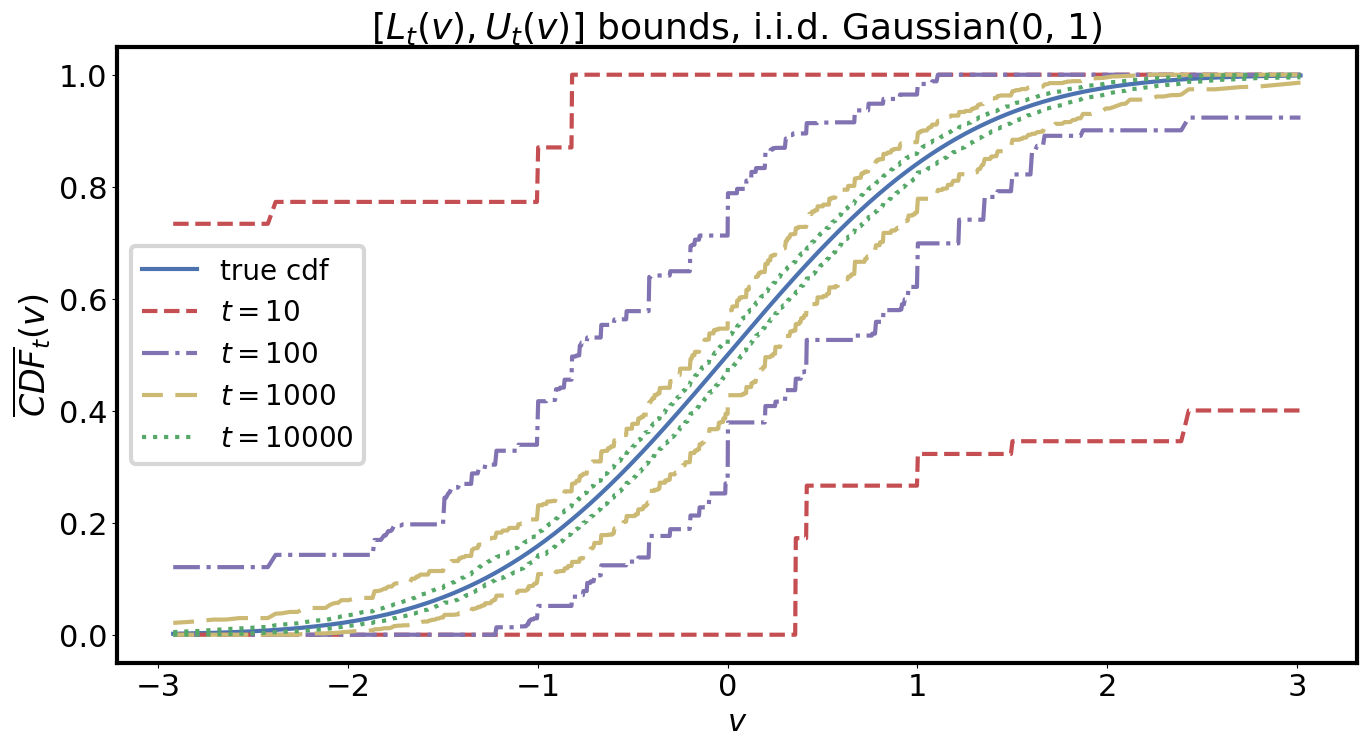

In [6]:
def flass(seed=4546):
    from math import exp, erfc, log, sqrt, atan, pi, tan
    from numpy.random import default_rng

    mu, sigma = 0, 1
    T = 10000
    
    rng = default_rng(seed)
    data = rng.normal(mu, sigma, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'Gaussian({mu}, {sigma})',
                cdf = lambda slf, x: 1/2 * erfc((mu - x)/(sqrt(2)*sigma)),
               )
    
    ref = Anon(cdf = lambda slf, x: 1/2 + atan(x)/pi,
               ppf = lambda slf, x: tan(pi*(x - 1/2)),
               sf = lambda slf, x: 1/2 - atan(x)/pi,
               isf = lambda slf, x: -tan(pi*(x - 1/2)),
              )
    
    plotit(data, true, ref, extra=[10, 100, 1000], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, i.i.d. Gaussian({mu}, {sigma})'],
           files=[None, 'gaussianboundwidth.pdf', 'gaussiancurves.pdf'],
           compare=[Anon(desc = f'Gaussian({mu + shift}, {shift*sigma})',
                         data = rng.normal(mu + shift, shift*sigma, size=T)
                        )
                    for shift in (100, 10000)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('symlog', linthresh=1), None ],
          )
    
flass()

# Nonstationary Example

## Continuous Polya Urn
$$
\begin{aligned}
X_t &\sim \text{Beta}\left(2 + \gamma_t \sum_{s < t} 1_{X_s > 1/2}, 2 + \gamma_t \sum_{s < t} 1_{X_s < 1/2} \right)
\end{aligned}
$$
Note slowness is due to simulation and calculation of the exact CDF, not due to bounds calculation.  We're using the uniform$([0,1])$ distribution as reference measure, but this gets increasingly less smooth as $T$ increases.

Suppose $\gamma_t = t^q$.  In the most extreme case that $\left(t = \sum_{s \leq t} 1_{X_s > 1/2}\right)$, the conditional distribution at time $t$ is $\text{Beta}\left(x; 2 + t \gamma_t, 2\right) \leq e^{-1} t \gamma_t + O(1)$, hence the density of $\mathbb{P}_t$ wrt the uniform distribution is at most $\frac{d\mathbb{P}_t}{dU} \leq O(1) + e^{-1} t^{-1} \sum_{s \leq t} s \gamma_s \leq O(t^{1 + q})$.

(2.3794733192202053, 33.21168050586191)
[12] [988]
(32.0416377715996, 3.549516053482506)
[951] [49]


<Figure size 640x480 with 0 Axes>

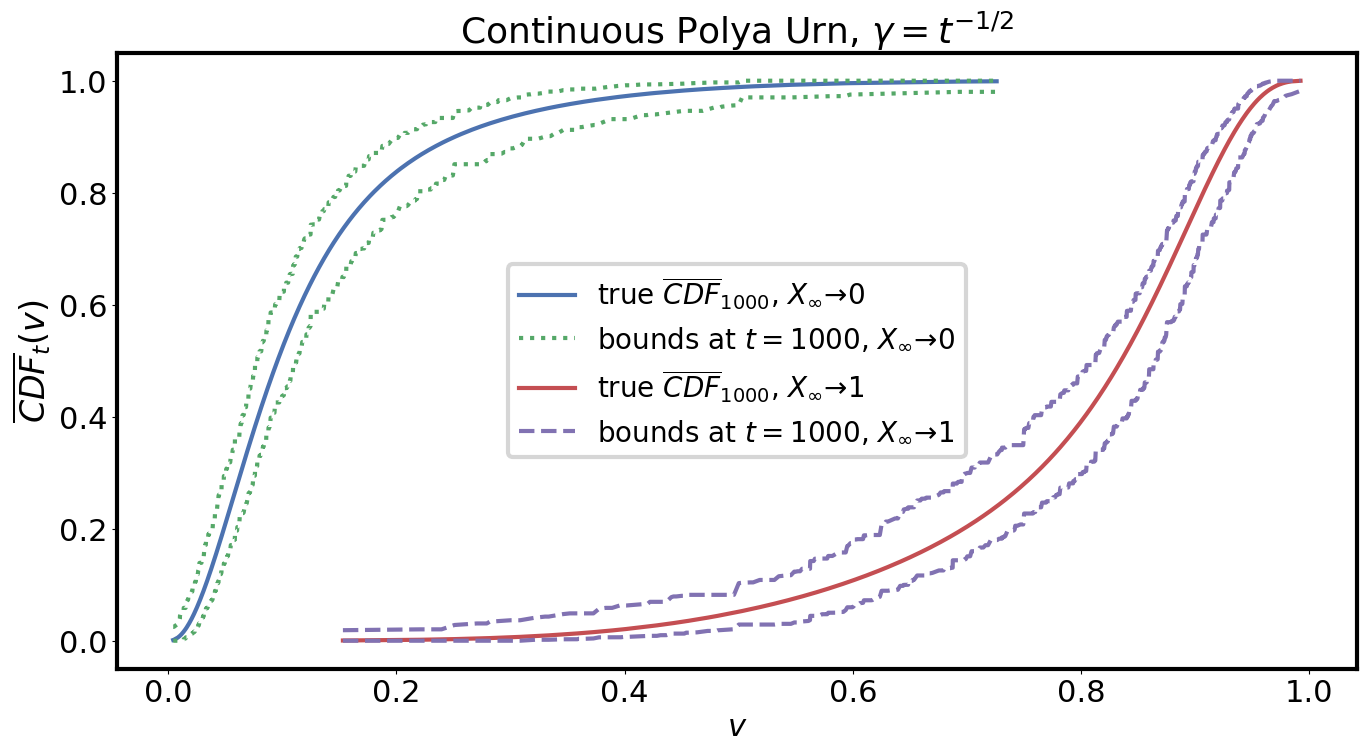

In [7]:
def megaplotit(datasets, trues, ref, title=None, hack=None, file=None):
    from math import sqrt, log, pi
    from scipy.interpolate import interp1d
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-v0_8-deep')
    
    for n, (data, true) in enumerate(zip(datasets, trues)):
        T = len(data)    
        nxvals = 1000
        ecdfx = np.sort(data)
        ecdfy = np.arange(1, len(data)+1)/float(len(data))
        probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
        exactcdfy = np.array([ true.cdf(x) for x in probevals ])
        
        counts = StreamingECDF()
        for x in data:
            counts.addobs(x)        
        icey = counts.freeze()
        lbcdfy = np.array([ getGenericLowerBound(x, icey, conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
        ubcdfy = np.array([ getGenericUpperBound(x, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
        
        plt.plot(probevals, exactcdfy, label=f'true $\\overline{{CDF}}_{{{T}}}$, {true.desc}', color=f'C{2*n}', linestyle=linestyle_tuple[0][1], linewidth=megalw)
        plt.plot(probevals, lbcdfy, label=f'bounds at $t={T}$, {true.desc}', color=f'C{2*n+1}', linestyle=linestyle_tuple[n+1][1], linewidth=megalw)
        plt.plot(probevals, ubcdfy, label=None, color=f'C{2*n+1}', linestyle=linestyle_tuple[n+1][1], linewidth=megalw)
        
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$\\overline{CDF}_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(title or f'wazzup', fontsize=megafs+6)
    if hack:
        hack(fig, ax)
    if file:
        plt.savefig(file, bbox_inches='tight')

def flass():
    from math import log
    from scipy.special import betainc, logsumexp
    from scipy.optimize import minimize_scalar
    import numpy as np
    from numpy.random import default_rng
    from fractions import Fraction
    
    def logbetapdf(a, b, p):
        from math import log1p
        from scipy.special import betaln
                
        return (b - 1) * log1p(-p) + (a - 1) * log(p) - betaln(a, b)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    T = 1000
    logT = log(T)
    
    datasets = []
    trues = []
    for limit, seed in enumerate((4548, 4550)):
        rng = default_rng(seed)
        data = []
        betas = []
        sumxgthalf = [0]
        sumxleqhalf = [0]
        powt = -1/2
        for t in range(1, T+1):
            betaa = 2 + (t**powt) * sumxgthalf[0] 
            betab = 2 + (t**powt) * sumxleqhalf[0]
            data.append(rng.beta(betaa, betab))
            betas.append((betaa, betab))
            (sumxgthalf if 2 * data[-1] > 1 else sumxleqhalf)[0] += 1
    
        print(f'{betas[-1]}')
        print(f'{sumxgthalf} {sumxleqhalf}')
        data = np.array(data)        
        mode = (betas[-1][0] - 1) / (betas[-1][0] + betas[-1][1] - 2)
        res = minimize_scalar(lambda x: -logsumexp([ logbetapdf(a, b, x) - logT for (a, b) in betas ]),
                              bounds=(min(1/2, mode), max(1/2, mode)),
                              method='bounded')
        assert res.success, (mode, res)
    
        true = Anon(desc = f'$X_\infty \\to {limit}$',
                    cdf = (lambda z: (lambda slf, x: sum(betainc(a, b, x) for (a, b) in z)/T))(betas),
                    mode = res.x,
                   )

        datasets.append(data)
        trues.append(true)
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    megaplotit(datasets, trues, ref, 
               title=f'Continuous Polya Urn, $\\gamma = t^{{{Fraction(powt)}}}$',
               file='contpolyatwoseeds.pdf')

# seed 4550 concentrates at 1
# seed 4548 concentrates at 0
flass()

T = 100000 powt = -1 betas = (2.49808, 2.50191)
T = 100000 powt = -0.5 betas = (2.0379473319220205, 318.1866564072557)
T = 100000 powt = 0 betas = (5, 99998)
extra = [  130   170   221   289   377   492   642   837  1092  1425  1858  2424
  3162  4124  5379  7017  9152 11937 15570 20309 26489 34551 45065 58780
 76668]


<Figure size 640x480 with 0 Axes>

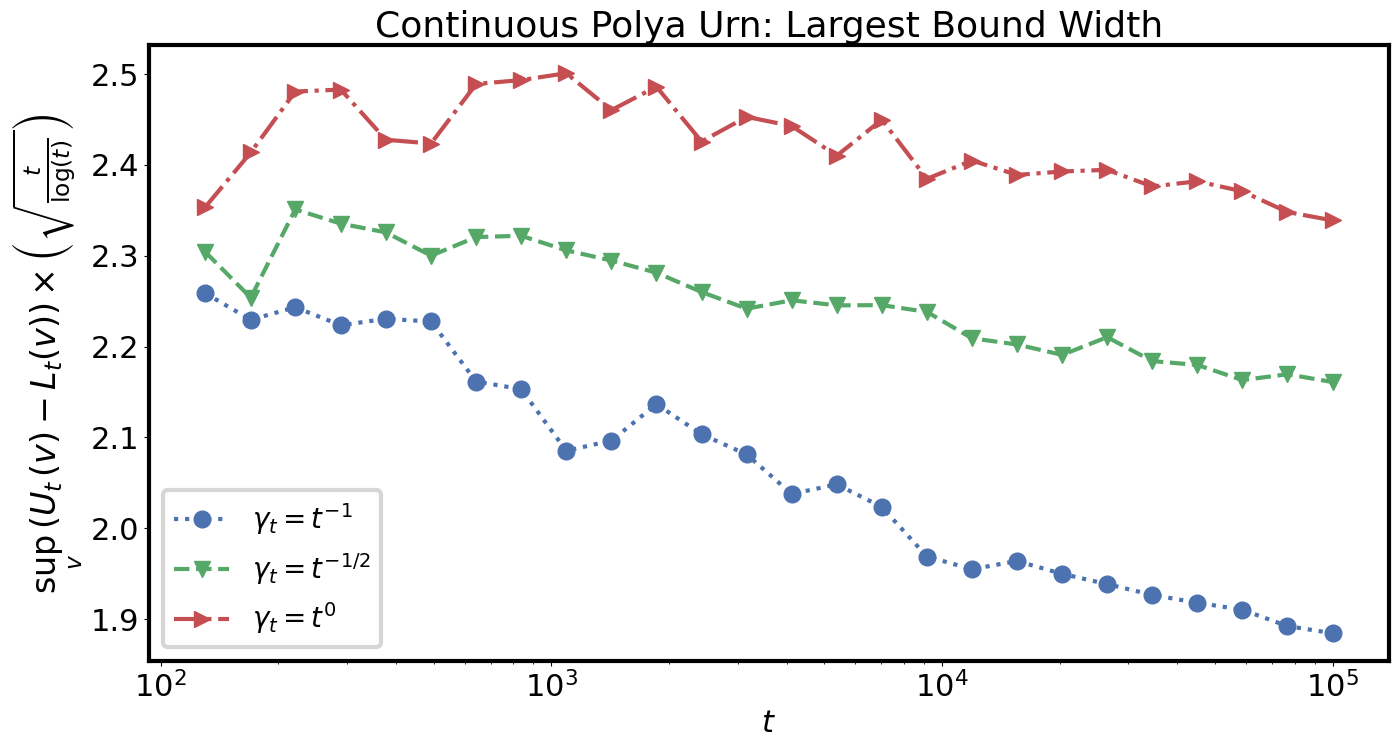

In [8]:
def ultraplotsupnorm(datasets, trues, ref, extra=[], title=None, hack=None, file=None):
    from tqdm.notebook import tqdm
    from math import sqrt, log, pi, exp
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    print(f'extra = {extra}')
        
    markers = "ov>^<8pP"
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-v0_8-deep')
    
    for n, (data, true) in tqdm(list(enumerate(zip(datasets, trues))), desc='powt', position=0, leave=False):
        times = []
        supnorms = []
        for t in tqdm(list(itertools.chain(extra, [len(data)])), desc='times', position=1, leave=False):
            counts = StreamingECDF()
            for x in data[:t]:
                counts.addobs(x)        
            icey = counts.freeze()
            
            from scipy.optimize import minimize_scalar
            def negboundwidth(logx):
                lb = getGenericLowerBound(exp(logx), icey, conf / 2, refsf = ref.sf, refisf = ref.isf)
                ub = getGenericUpperBound(exp(logx), icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf)
                return lb - ub
            
            logmode = true.logmodefunc(t)
            bracket = [logmode/2, logmode] 
            res = minimize_scalar(negboundwidth, bracket=bracket, method='brent')
            assert res.success, res
            lbmode = getGenericLowerBound(exp(logmode), icey, conf / 2, refsf = ref.sf, refisf = ref.isf)
            ubmode = getGenericUpperBound(exp(logmode), icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf)
            times.append(t)
            supnorms.append(sqrt(t/log(t))*(-res.fun))
            
            #print(f'desc={true.desc} t={t} mode={logmode} modewidth={ubmode - lbmode} res.x={res.x} res.fun={res.fun}')

        plt.plot(times, supnorms, label=f'{true.desc}', color=f'C{n}', marker=markers[n], markersize=megafs-8,
                 linestyle=linestyle_tuple[n+1][1], linewidth=megalw)
        
    ax.set_xlabel(f'$t$', fontsize=megafs+2)
    ax.set_ylabel('$\\sup_v \\, \\left( U_t(v) - L_t(v) \\right) \\times \\left(\\sqrt{\\frac{t}{\\log(t)}}\\right)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(title or f'wazzup', fontsize=megafs+6)
    if hack:
        hack(fig, ax)
    if file:
        plt.savefig(file, bbox_inches='tight')

def flass():
    from math import log, exp, log1p
    from scipy.special import betainc, logsumexp
    from scipy.optimize import minimize_scalar
    import numpy as np
    from numpy.random import default_rng
    from fractions import Fraction
    
    def logbetapdf(a, b, logp, reverse):
        from scipy.special import betaln
        assert logp < 0, logp
        
        if reverse:
            a, b = b, a
                        
        logoneminusp = log1p(-exp(logp))
                
        return (b - 1) * logoneminusp + (a - 1) * logp - betaln(a, b)
    
    def logpdf(betas, logp, reverse):
        t = len(betas)
        return logsumexp([ logbetapdf(a, b, logp, reverse) - log(t) for (a, b) in betas ])
        
    def findlogmode(betas):
        lastmode = (betas[-1][0] - 1) / (betas[-1][0] + betas[-1][1] - 2)
        reverse = (lastmode <= 1/2)
        bounds = (-100, log(1/2))
        res = minimize_scalar(lambda logx: -logpdf(betas, logx, reverse=(lastmode <= 1/2)),
                              bounds=bounds,
                              method='bounded',
                             )
        assert res.success, (lastmode, res)
        return log1p(-exp(res.x)) if reverse else res.x
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    logbase10T = 5
    T = 10**logbase10T
    
    datasets = []
    trues = []
    seed = 4548
    # seed 4550 concentrates at 1
    # seed 4548 concentrates at 0
    for powt in (-1, -1/2, 0):
        rng = default_rng(seed)
        data = []
        betas = []
        sumxgthalf = [0]
        sumxleqhalf = [0]
        for t in range(1, T+1):
            betaa = 2 + (t**powt) * sumxgthalf[0] 
            betab = 2 + (t**powt) * sumxleqhalf[0]
            data.append(rng.beta(betaa, betab))
            betas.append((betaa, betab))
            (sumxgthalf if 2 * data[-1] > 1 else sumxleqhalf)[0] += 1
    
        data = np.array(data)

        true = Anon(desc = f'$\\gamma_t = t^{{{Fraction(powt)}}}$',
                    neglogpdf = (lambda z: (lambda slf, logx, t:  -logpdf(z[:t], logx)))(betas),
                    logmodefunc = (lambda z: (lambda slf, t: findlogmode(z[:t])))(betas),
                   )
        
        datasets.append(data)
        trues.append(true)
        print(f'T = {T} powt = {powt} betas = {betas[-1]}')
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    ultraplotsupnorm(datasets, trues, ref,
                     extra=np.logspace(start=2, stop=logbase10T, num=27)[1:-1].astype(int),
                     title='Continuous Polya Urn: Largest Bound Width',
                     hack=lambda fig, ax: (ax.set_xscale('log'),),
                     file='contpolygammasweep.pdf')

flass()